# Tensorflow로 모델링하는 2가지 방법
1. `Sequential` 모델링을 활용하는 방법
  * keras에서 제공하는 레이어들을 이어 붙여 가면서 모델링하는 방법
  * 쉽고 빠르게 모델링이 가능하다.
  * 레이어들에 대한 커스터마이징이 조금 힘들다.
2. `Functional API`를 활용하는 방법
  * 개발자가 직접 레이어를 정의해서 keras의 레이어처럼 사용하게 할 수 있다.(`tf.keras.layers` 상속)
  * 기타 평가 방식이나 Loss, Optimizer 등등을 직접 정의해서 사용할 수 있다.

# tf.data 사용하기
* 일반적인 배열이 아닌, 병렬 처리 된 배열을 이용하여 매우 빠른 속도로 데이터의 입출력이 가능하게 된다.
* `dataset`이라는 개념을 이용해서 `feature`, `label`을 손쉽게 관리할 수 있다.

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets

In [ ]:
mnist = datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train[..., tf.newaxis]
X_test  = X_test[..., tf.newaxis]

X_train, X_test = X_train/255.0, X_test/255.0

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## tf.data의 함수들
* `from_tensor_slices()` : `feature`, `label`을 합친 데이터세트(**ds**)를 생성
* `shuffle()` : 데이터 세트에 있는 데이터를 랜덤하게 섞어줌
* `batch()` : 배치 생성하기

In [ ]:
# 데이터 세트를 제너레이트할 데이터를 넣어 준다. 데이터를 병렬로 처리할 수 있게 된다. ( 속도가 매우 빨라진다. )
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# 데이터 섞기
train_ds = train_ds.shuffle(1024) # 매개변수에 들어가는 숫자는 랜덤 시드가 아닌 랜덤을 생성하기 위한 버퍼 사이즈( 1kb를 일반적으로 설정함. )

# 배치 생성
train_ds = train_ds.batch(32) # iteration 할 때마다 batch_size만큼 데이터가 나온다. ( 여기서는 32 )

In [ ]:
# 테스트 ds 만들기
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# 테스트 세트는 셔플이 필요 없다. 배치만 설정해 주자.
test_ds = test_ds.batch(32)

`take()` 함수를 이용하면 데이터를 (이미 정해진) 배치 사이즈만큼 데이터를 꺼내올 수 있다.

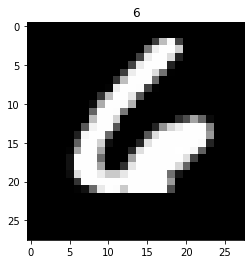

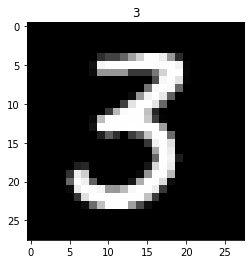

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(2):
  # print(images.shape, labels.shape)
  image = images[0, ..., 0]
  label = labels.numpy()[0]

  plt.title(label)
  plt.imshow(image, cmap='gray')
  plt.show()

## tf.data를 이용해서 Sequantial 모델 훈련하기

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D # Feature Extraction Layers
from tensorflow.keras.layers import Flatten, Dense # Fully Connected Layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dropout

model = Sequential([
                    
  ##### Feature Extraction #####
  Conv2D(filters=32, kernel_size=3, padding='SAME', input_shape=(28, 28, 1), activation='relu'),
  Conv2D(filters=32, kernel_size=3, padding='SAME', activation='relu'),
  MaxPool2D(pool_size=(2, 2)),

  Dropout(0.25), # 가중치를 0으로 만들 데이터의 비율 지정(사용하지 않을 데이터의 비율 지정) - 과대적합 방지

  Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu'),
  Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu'),
  MaxPool2D(pool_size=(2, 2)),

  Dropout(0.25),

  ##### Fully Connected #####
  Flatten(),
  Dense(512, activation='relu'),
  Dense(10, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# # tf.data를 이용해서 훈련
# model.fit(train_ds, epochs=1)

# @tf.function
* `Functional API`에서 가장 많이 사용되는 데코레이터 패턴, Tensorflow 세션( 계산그래프 )에서 관리하는 함수가 될 수 있도록 해준다.
* `@tf.function`이 붙은 함수는 계산그래프가 모두 그려지고나서 실제 학습이 되면서 수행되기 때문에 `Tensorflow`의 리소스를 이용할 수 있게 된다.
* 학습 및 테스트하는 함수에 붙는다.

In [ ]:
# Loss Function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Optimizer
optimizer = tf.keras.optimizers.Adam()

# Train / Test Loss를 평균으로 관리
train_loss = tf.keras.metrics.Mean(name='train_loss') 
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
  # 자동 미분 수행을 위한 환경 만들기
  #  loss를 구하는 과정
  with tf.GradientTape() as tape: # 미분 준비 과정
    # 1. 예측
    prediction = model(images) # 모델이 훈련 모드가 된다.

    # 2. loss 구하기
    loss = loss_object(labels, prediction)

  # 3. 오차 역전파 수행 ( grads : 수정 되어야할 기울기 벡터 )
  grads = tape.gradient(loss, model.trainable_variables) # model.trainable_variables : 가중치, 편향 정보 ( 갱신이 가능한 ... )

  # 4. 최적화 (apply_gradients : 매개변수 갱신) 
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  # loss, accuracy 기록
  train_loss(loss)
  train_accuracy(labels, prediction)

In [ ]:
@tf.function
def test_step(images, labels):
  prediction = model(images)
  t_loss = loss_object(labels, prediction)

  test_loss(t_loss)
  test_accuracy(labels, prediction)

모델 재실행

In [ ]:
model = Sequential([
                    
  ##### Feature Extraction #####
  Conv2D(filters=32, kernel_size=3, padding='SAME', input_shape=(28, 28, 1), activation='relu'),
  Conv2D(filters=32, kernel_size=3, padding='SAME', activation='relu'),
  MaxPool2D(pool_size=(2, 2)),

  Dropout(0.25), # 가중치를 0으로 만들 데이터의 비율 지정(사용하지 않을 데이터의 비율 지정) - 과대적합 방지

  Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu'),
  Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu'),
  MaxPool2D(pool_size=(2, 2)),

  Dropout(0.25),

  ##### Fully Connected #####
  Flatten(),
  Dense(512, activation='relu'),
  Dense(10, activation='softmax')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)         

# Functional API 훈련하기

In [ ]:
epochs = 10

for epoch in range(epochs):
  # 1 에폭은 모든 데이터에 대한 학습
  for images, labels in train_ds:
    train_step(images, labels)
  
  # 테스트 수행
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = "Epoch {}, Train Loss : {:.3f}, Train Accuracy : {:.3f} /// Test Loss : {:.3f}, Test Accuracy : {:.3f}"
  print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100,
                                   test_loss.result(), test_accuracy.result() * 100))

Epoch 1, Train Loss : 0.022, Train Accuracy : 99.314 /// Test Loss : 0.033, Test Accuracy : 99.024
Epoch 2, Train Loss : 0.021, Train Accuracy : 99.353 /// Test Loss : 0.033, Test Accuracy : 99.041
Epoch 3, Train Loss : 0.020, Train Accuracy : 99.392 /// Test Loss : 0.032, Test Accuracy : 99.056
Epoch 4, Train Loss : 0.019, Train Accuracy : 99.424 /// Test Loss : 0.034, Test Accuracy : 99.061
Epoch 5, Train Loss : 0.018, Train Accuracy : 99.449 /// Test Loss : 0.034, Test Accuracy : 99.077
Epoch 6, Train Loss : 0.017, Train Accuracy : 99.473 /// Test Loss : 0.036, Test Accuracy : 99.077
Epoch 7, Train Loss : 0.016, Train Accuracy : 99.497 /// Test Loss : 0.037, Test Accuracy : 99.091
Epoch 8, Train Loss : 0.016, Train Accuracy : 99.515 /// Test Loss : 0.037, Test Accuracy : 99.099
Epoch 9, Train Loss : 0.015, Train Accuracy : 99.534 /// Test Loss : 0.038, Test Accuracy : 99.106
Epoch 10, Train Loss : 0.015, Train Accuracy : 99.551 /// Test Loss : 0.039, Test Accuracy : 99.108
